In [1]:
import numpy as np
import pandas as pd
import os
os.environ['USE_PROPACK'] = '1'
from random import sample
import time
from tools import roseland, nystrom, get_acc3

In [2]:
current_dir = '/home/janrose/EECS553/Project/eecs553_Roseland-main'
add_noise = 0
clean_subset = 0
N = 60399
iter = 15
kmean_iter = 5
Beta = [0.3, 0.4, 0.5]

In [3]:
data = (pd.read_csv("Patient1Values.csv")).to_numpy() #this should be the data after processing it

In [4]:
data_new = np.array(data[:, 3:10], dtype=float) #feature vectors
label = np.array(data[:,10:11], dtype=int) #last col is the activity label
data_new = data_new[:N]
label = label[:N].flatten()
sorted_indices = label.argsort()
data_new = data_new[sorted_indices]
label = label[sorted_indices]

In [29]:
for beta in Beta:
    subset_size = round(N**beta)
    embed_dim = min(50, subset_size - 1)
    
    acc_roseland = np.zeros((iter, embed_dim))
    acc_nys = np.zeros((iter, embed_dim))
    Time_nys = np.zeros(iter)
    Time_roseland = np.zeros(iter)

    for ii in range(iter):
        # Landmarks
        subind = sample(range(N), N)  # Random permutation of indices
        subset = data_new[subind[:subset_size]]

        # Roseland
        start_time = time.time()
        roseland_embed, _ = roseland.Roseland(data_new, embed_dim, subset, 1)
        time_roseland = time.time() - start_time
        Time_roseland[ii] = time_roseland

        # Nystrom
        start_time = time.time()
        nystrom_embed, _ = nystrom.Nystrom(data_new, subset, embed_dim, 0)
        time_nys = time.time() - start_time
        Time_nys[ii] = time_nys
        nystrom_embed = nystrom_embed[subset_size:, 1:]

        # Accuracy
        acc_roseland[ii, :] = get_acc3.get_acc3(roseland_embed, label, kmean_iter)
        acc_nys[ii, :] = get_acc3.get_acc3(nystrom_embed, label, kmean_iter)

    path = os.path.join(current_dir, 'new_dataset', f'beta{beta:.1f}')
    os.makedirs(path, exist_ok=True)
    os.chdir(path)

    roseland_embed = roseland_embed[:, :3]
    nystrom_embed = nystrom_embed[:, :3]

    np.save('label_physio.npy', label)
    np.save('roseland_embed_physio.npy', roseland_embed)
    np.save('nystrom_embed_physio.npy', nystrom_embed)
    np.save('acc_roseland_physio.npy', acc_roseland)
    np.save('acc_nys_physio.npy', acc_nys)
    np.save('time_nys_physio.npy', Time_nys)
    np.save('time_roseland_physio.npy', Time_roseland)

/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [5]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


In [36]:
Beta = [0.3, 0.4, 0.5]
Roseland_dict = {Beta[0]:None,Beta[1]:None,Beta[2]:None}
nystrom_dict = {Beta[0]:None,Beta[1]:None,Beta[2]:None}

In [37]:
for beta in Beta:
    subset_size = round(N**beta)
    embed_dim = min(50, subset_size - 1)
    
    acc_roseland = np.zeros((iter, embed_dim))
    acc_nys = np.zeros((iter, embed_dim))
    Time_nys = np.zeros(iter)
    Time_roseland = np.zeros(iter)

    for ii in range(iter):
        # Landmarks
        subind = sample(range(N), N)  # Random permutation of indices
        subset = data_new[subind[:subset_size]]

        # Roseland
        start_time = time.time()
        #roseland_embed, _ = roseland.Roseland(data_new, embed_dim, subset, 1)
        denoise = True
 #def Roseland(data, dim, ref, denoise):
        n = data_new.shape[0]

        # form affinity matrix wrt the ref set
        affinity_ext = cdist(data_new, subset, metric='sqeuclidean')

        # affinity matrix W
        sig = np.median(np.median(affinity_ext, axis=1))

        if denoise:
            W_ref = np.exp(-6 * affinity_ext / sig)
        else:
            W_ref = np.exp(-5 * affinity_ext / sig)
    
        W_ref = csr_matrix(W_ref)
        # make W row stochastic
        D = W_ref.dot(np.sum(W_ref, axis=0).T)
        D = np.sqrt(np.linalg.pinv(D))

        # form sparse D = D^(-.5)
        D = csr_matrix((D.A.flatten(), (np.arange(n), np.arange(n))), shape=(n, n))
        W_ref = D.dot(W_ref)

        # SVD on D * W_ref
        k = min(min(W_ref.shape), embed_dim+1)
        U, S, _ = svds(W_ref, k=k, solver='propack')
        U = D.dot(U[:, 1:])
        S = S[1:]**2

        roseland_embed, roseland_vals = U, S
        
        time_roseland = time.time() - start_time
        Time_roseland[ii] = time_roseland

        # Nystrom
        start_time = time.time()
        nystrom_embed, nystrom_vals = nystrom.Nystrom(data_new, subset, embed_dim, 0)
        time_nys = time.time() - start_time
        Time_nys[ii] = time_nys
        nystrom_embed = nystrom_embed[subset_size:, 1:]

        # Accuracy
        acc_roseland[ii, :] = get_acc3.get_acc3(roseland_embed, label, kmean_iter)
        acc_nys[ii, :] = get_acc3.get_acc3(nystrom_embed, label, kmean_iter)
    
    roseland_embed = roseland_embed[:, :3]
    Roseland_dict[beta] = (roseland_embed[:, :3],roseland_vals)                      
    nystrom_embed = nystrom_embed[:, :3]
    nystrom_dict[beta] = (nystrom_embed[:, :3],nystrom_vals)   

/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/home/janrose/.local/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [89]:
#print(np.sort(nystrom_dict[0.5][1]))

[7.51302969e-08 8.32774888e-08 9.66412208e-08 1.05763020e-07
 1.15560010e-07 1.51127677e-07 1.63432315e-07 1.84838787e-07
 2.43312558e-07 2.94848381e-07 3.14099294e-07 4.59719006e-07
 6.29189658e-07 8.86872706e-07 1.06676156e-06 1.22433333e-06
 1.54211110e-06 1.69570365e-06 2.04288864e-06 2.48133545e-06
 2.58369551e-06 4.13076891e-06 5.23584725e-06 6.55736886e-06
 8.68992583e-06 1.44878418e-05 1.63399413e-05 1.67772262e-05
 2.09824005e-05 2.33638416e-05 2.95293871e-05 3.52345138e-05
 5.23298975e-05 8.28187593e-05 1.10418575e-04 1.40745095e-04
 1.51547245e-04 3.18433595e-04 4.27467818e-04 6.37261336e-04
 8.52725524e-04 1.44596232e-03 1.67651243e-03 2.62153946e-03
 5.48185486e-03 7.43922693e-03 1.88897390e-02 2.69425300e-02
 3.75030856e-02 8.89874264e-02 1.00000000e+00]


In [15]:
#Plotting the Embeddings
Roseland_embed_physio3 = np.load('./new_dataset/beta0.3/roseland_embed_physio.npy')
nystrom_embed_physio3 = np.load('./new_dataset/beta0.3/nystrom_embed_physio.npy')
Roseland_embed_physio4 = np.load('./new_dataset/beta0.4/roseland_embed_physio.npy')
nystrom_embed_physio4 = np.load('./new_dataset/beta0.4/nystrom_embed_physio.npy')
Roseland_embed_physio5 = np.load('./new_dataset/beta0.5/roseland_embed_physio.npy')
nystrom_embed_physio5 = np.load('./new_dataset/beta0.5/nystrom_embed_physio.npy')

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

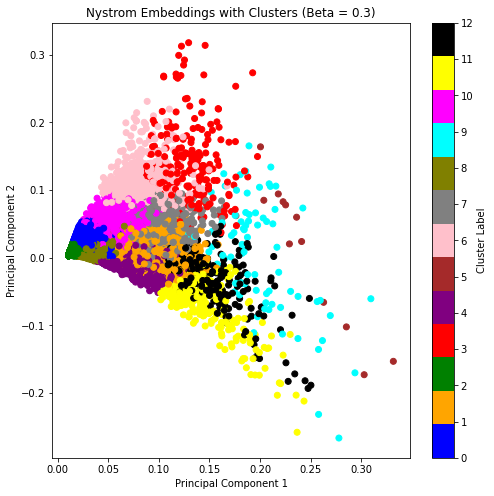

In [45]:
kmeans = KMeans(n_clusters=13)
clusters = kmeans.fit_predict(nystrom_embed_physio3)
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow','black']
cmap_custom = ListedColormap(cluster_colors)
# Step 2: Visualize Clusters
plt.figure(figsize=(8,8))
plt.scatter(nystrom_embed_physio3[:, 0], nystrom_embed_physio3[:, 1], c=clusters, cmap=cmap_custom)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Nystrom Embeddings with Clusters (Beta = 0.3)')
plt.colorbar(ticks=range(13), label='Cluster Label')

plt.show()

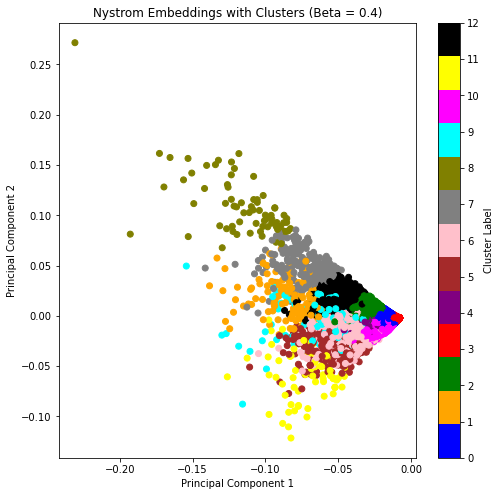

In [47]:
kmeans = KMeans(n_clusters=13)
clusters = kmeans.fit_predict(nystrom_embed_physio4)
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow','black']
cmap_custom = ListedColormap(cluster_colors)
# Step 2: Visualize Clusters
plt.figure(figsize=(8,8))
plt.scatter(nystrom_embed_physio4[:, 0], nystrom_embed_physio4[:, 1], c=clusters, cmap=cmap_custom)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Nystrom Embeddings with Clusters (Beta = 0.4)')
plt.colorbar(ticks=range(13), label='Cluster Label')

plt.show()

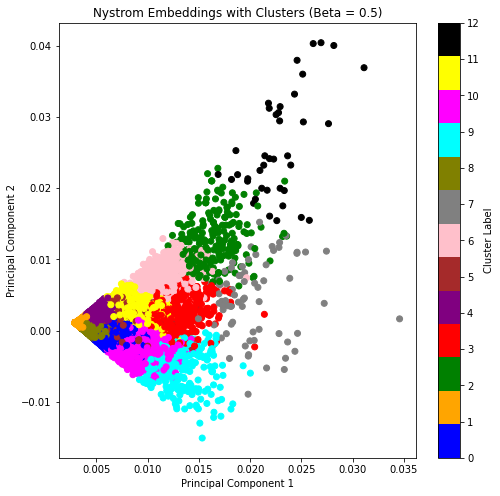

In [48]:
kmeans = KMeans(n_clusters=13)
clusters = kmeans.fit_predict(nystrom_embed_physio5)
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow','black']
cmap_custom = ListedColormap(cluster_colors)
# Step 2: Visualize Clusters
plt.figure(figsize=(8,8))
plt.scatter(nystrom_embed_physio5[:, 0], nystrom_embed_physio5[:, 1], c=clusters, cmap=cmap_custom)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Nystrom Embeddings with Clusters (Beta = 0.5)')
plt.colorbar(ticks=range(13), label='Cluster Label')

plt.show()

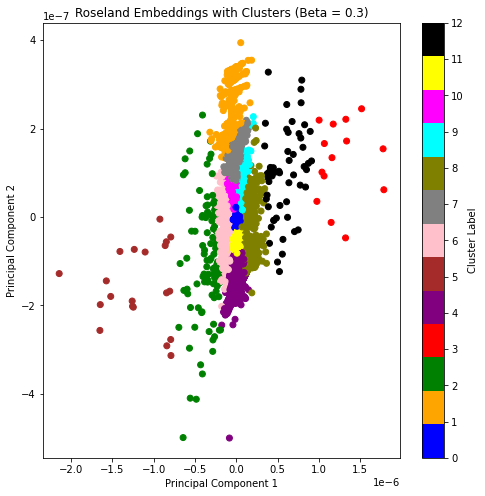

In [42]:
kmeans = KMeans(n_clusters=13)
clusters = kmeans.fit_predict(Roseland_embed_physio3)
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow','black']
cmap_custom = ListedColormap(cluster_colors)
# Step 2: Visualize Clusters
plt.figure(figsize=(8,8))
plt.scatter(Roseland_embed_physio3[:, 0], Roseland_embed_physio3[:, 1], c=clusters, cmap=cmap_custom)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Roseland Embeddings with Clusters (Beta = 0.3)')
plt.colorbar(ticks=range(13), label='Cluster Label')

plt.show()

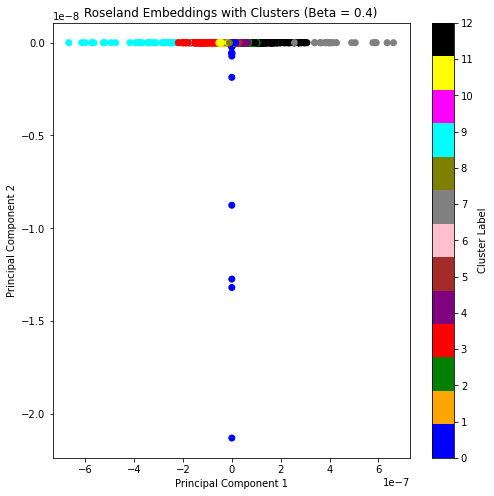

In [18]:
kmeans = KMeans(n_clusters=13)
clusters = kmeans.fit_predict(Roseland_embed_physio4)
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow','black']
cmap_custom = ListedColormap(cluster_colors)
# Step 2: Visualize Clusters
plt.figure(figsize=(8,8))
plt.scatter(Roseland_embed_physio4[:, 0], Roseland_embed_physio4[:, 1], c=clusters, cmap=cmap_custom)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Roseland Embeddings with Clusters (Beta = 0.4)')
plt.colorbar(ticks=range(13), label='Cluster Label')

plt.show()

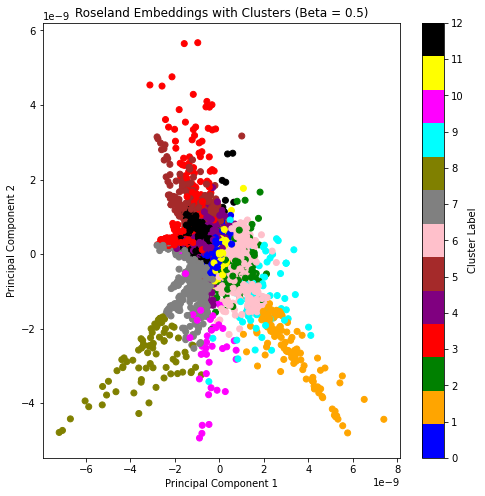

In [44]:
kmeans = KMeans(n_clusters=13)
clusters = kmeans.fit_predict(Roseland_embed_physio5)
cluster_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow','black']
cmap_custom = ListedColormap(cluster_colors)
# Step 2: Visualize Clusters
plt.figure(figsize=(8,8))
plt.scatter(Roseland_embed_physio5[:, 0], Roseland_embed_physio5[:, 1], c=clusters, cmap=cmap_custom)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Roseland Embeddings with Clusters (Beta = 0.5)')
plt.colorbar(ticks=range(13), label='Cluster Label')

plt.show()